# Data extraction


In [2]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# List of years available and used
years = [2015,2016,2017,2018,2019,2020]

# Size of years file in GB
year_size = np.array([3.3,2.3,5.2,4.8,3.6,.9])

# Number of rows in file of 2020 (computed once "by hand", as long as this file is not too heavy)
rows2020 = 5244449

# Estimation of number of rows in each file
year_rows = year_size*rows2020/.9

# Which correspond to n chunks of size one million
chunks_number = np.rint(year_rows/1e6).astype(int)

# Which means we have to take n random rows in each chunk to get a sample of 200,000 rows per year
rows_in_chunk = np.rint(2*1e5/chunks_number).astype(int)

In [ ]:
# As long as year 2017 crashes (even run alone), we change parameters for it
rows_in_chunk[2] = 666
chunks_number[2] = 300

# And we chose different chunk size for this year
chunk_sizes = [1e6,1e6,1e5,1e6,1e6,1e6]

In [ ]:
rows_in_chunk, chunks_number

In [ ]:
# Data files all have the following columns
Index = ['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences','probas', 'urls', 'phase']

In [ ]:
# Useful function, when testing loops
def process_chunk(chunk,year):
        print(f'Processing chunk with {len(chunk)} rows, in file from year {year}')
        # print(chunk.columns)

In [ ]:
print("C'est parti, mon kiki !\n")
df = pd.DataFrame(columns=Index)
for iii, year in enumerate(years) :
    with pd.read_json(f'./Quotebank/quotes-{year}.json.bz2', lines=True, compression='bz2', chunksize=chunk_sizes[iii]) as df_reader:
        print(f"Start year {year} with chunks of size {int(chunk_sizes[iii])}")
        for chunk in df_reader:
            # process_chunk(chunk,year)
            df = pd.concat([df,chunk.sample(rows_in_chunk[iii])])
        print(f"Done with year {year}")
df = df.reset_index(drop=True)
df.to_json(f"./Quotebank/Sample.json.bz2",compression="bz2",lines=True,orient="records")
print("\nTout est bien qui finit bien")

# Data wrangling of the Quotebank dataset

This notebook is dedicated to developpe the datawrangling methods that will be used to clean the full Quotebank dataset used in our project. The methods are tested on a sample of the full database.

The sample is made frome 200'000 quotes of each years of interest (2015-2020) which should therefore contain $1.2 \cdot 10^6$ entries.

The script will proceed through the following steps:
  - drop of the duplicates
  - drop of the quotes for which the speaker is not identified (threshold to be defined)
  - drop the quotes in which the probability between one or more speaker his near each other (threshold to be defined)
  - drop of any quotes that is empty
  - keep only the speaker that has the most probability of being the author of the quote
    

In [2]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(10,7)})

### Getting the data
The previously extracted data sample (processed `Sample_creation.ipynb`) is imported in the notebook easily and relatively efficiently thanks to the json format. It takes about 2 [min/Mio quotes] which is totally satisfying.

In [4]:
%%time
#copy the path of the sample quotes: (to big to put in the git)
#ALEX: 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'
#JULES: ...
#MARIN: ...
#NICO: ...


path_2_data = 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'


#import the dataset sample
raw_data = pd.read_json(path_2_data + 'Sample.json.bz2',compression="bz2",lines=True)

raw_data.describe()

Wall time: 2min 20s


numOccurrences
count    1.263790e+06
mean     3.767778e+00
std      4.666187e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.300000e+04

Quick look at some entries in this dataframe

In [5]:
raw_data.sample(3)

quoteID                                          quotation  \
771255  2018-05-24-153757  Wildcat fuel in the form of English pastries a...   
871930  2019-01-04-018128                   free from religious association,   
376530  2016-02-21-011948  First of all, we must recognise the very hard ...   

              speaker       qids                date  numOccurrences  \
771255           None         [] 2018-05-24 18:03:00               1   
871930  David Whitney  [Q215478] 2019-01-04 15:39:03               1   
376530  Eric Boullier  [Q172767] 2016-02-21 08:55:00               4   

                                                   probas  \
771255  [[None, 0.9071], [Roxana Saberi, 0.0612], [Meg...   
871930          [[David Whitney, 0.9248], [None, 0.0752]]   
376530          [[Eric Boullier, 0.8848], [None, 0.1152]]   

                                                     urls phase  
771255  [https://news.northwestern.edu/stories/2018/ma...     E  
871930  [https://christiannews.net/2019/01/04/jesus-ne...     E  
376530  [http://www.pitpass.com/55504/McLaren-Honda-re...     E

Test to see if the ids are unique within the dataset

In [6]:
%%time
#Keeping the first occurence of the duplicates
size_bf = raw_data.shape[0]
df_raw = raw_data.copy().drop_duplicates(subset = 'quoteID', keep='first')
size_af = df_raw.shape[0]

print('{} dupplicates rows have been removed'.format(size_bf-size_af))
print('Unique rows in the data set:', df.quoteID.is_unique)

0 dupplicates rows have been removed
Unique rows in the data set: True
Wall time: 1.89 s


We can already drop the rows with probability = 1 to have an attributed speaker: this is theoretically not possible and probably due to the missfunctionning of the attribution model.

In [19]:
len_before = len(df_test)
IndexP1 = df_test[df_test['probas'].str.len() < 2].index

df_raw = df_raw.drop(IndexP1 , inplace=False)
len_after = len(df_test)

print('{} rows with probability = 1 have been removed'.format(len_before-len_after))

1 rows with probability = 1 have been removed


Extraction the probabilities linked to the two most probable speakers. We simply take the two first element of the list present in the column "probas" of the dataframe.

In [21]:
%%time
#highest probability
df = df_raw.copy()
df['p1'] = [i[0][1] for i in df['probas']]
df['p1'] = df['p1'].astype(float)

#second highest probability
df['p2'] = [i[1][1] for i in df['probas']]
df['p2'] = df['p2'].astype(float)

#difference between the two above
df['delta_p'] = df['p1']-df['p2']

#extracting the date
df['year'] = pd.DatetimeIndex(df['date']).year



Wall time: 4.3 s


Boxplot to analyze the presence of outliers, it seems that there is some problematic values:
 - p2 should be always smaller than 0.5 (otherwise it should be p1)
 - p1 - p2 should be always positive since p1>p2
 - low values in p1 should be removed

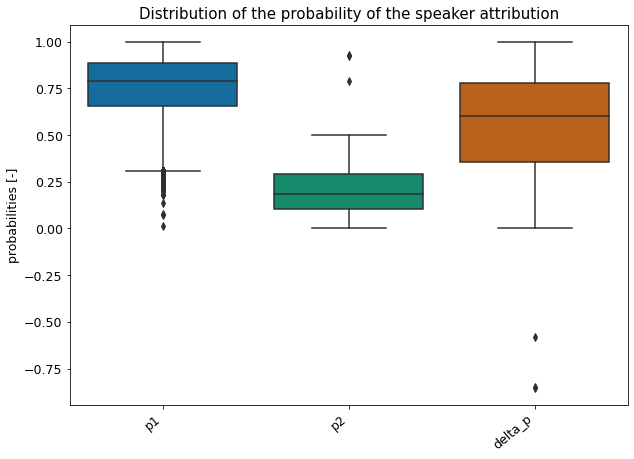

In [22]:
#boxplot to analyze the presence of outliers
data_plot = df.drop(['numOccurrences','year'], axis = 1)
ax = sns.boxplot(data = data_plot)
ax.set(ylabel='probabilities [-]')
ax.set_title('Distribution of the probability of the speaker attribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

Distribution in the forms of histograms, observation:
 - Strange drop in the distribution of p1 around x = 0.5

(-0.1, 1.1)

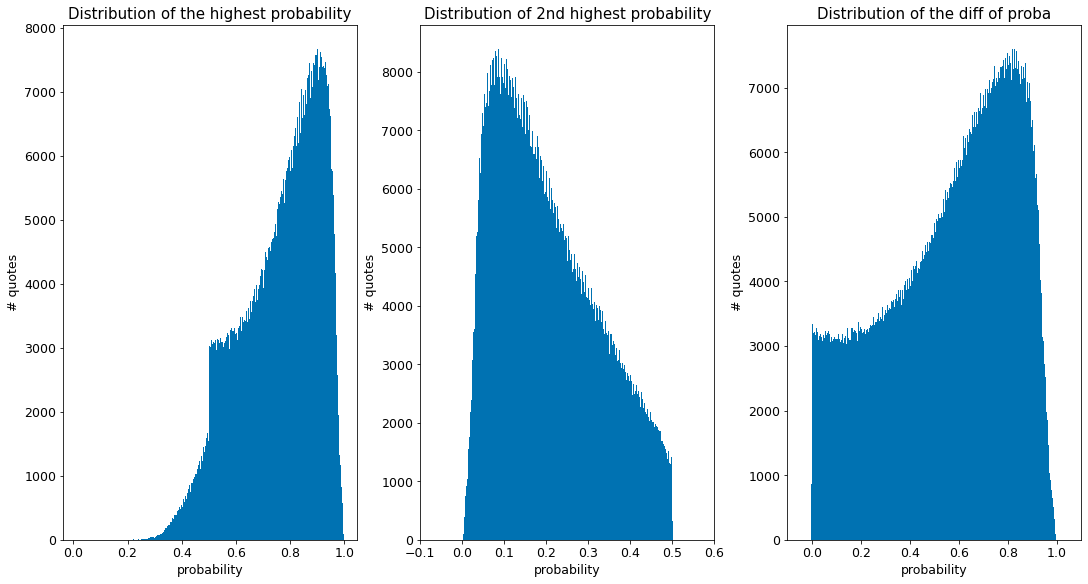

In [23]:
#histograms to better understand the distribution of the data
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 8))
ax[0].hist(df.p1, bins=500)
ax[0].set_title('Distribution of the highest probability')
ax[0].set_ylabel('# quotes')
ax[0].set_xlabel('probability')
#ax[0].set_xlim([-10000,600000])
#ax[0].set_ylim([0,340])

ax[1].hist(df.p2, bins=500)
ax[1].set_title('Distribution of 2nd highest probability')
ax[1].set_ylabel('# quotes')
ax[1].set_xlabel('probability')
ax[1].set_xlim([-0.1,0.6])
#ax[1].set_ylim([0,340])

ax[2].hist(df.delta_p, bins=500)
ax[2].set_title('Distribution of the diff of proba')
ax[2].set_ylabel('# quotes')
ax[2].set_xlabel('probability')
ax[2].set_xlim([-0.1,1.1])
#ax[2].set_ylim([0,340])

After the anlysis above we can drop the quotes for which the speaker
   - have meaningless probabilities
   - is not clearly identified (threshold to be defined: *threshold_min*)
   - is probably confused with another speaker (threshold to be defined: *threshold_diff*)
   - is not identified (None values)

In [24]:
#fixing the threshold (=> to low percentage of attribution to be considered in the analysis)
threshold_min = 0.5
threshold_diff = 0.3

#removing the rows that not pass the criterions
indexNames = df[
                        (df['p1'] < threshold_min)
                      | (df['delta_p'] < threshold_diff)
                      | (df['speaker'] == 'None')
                                                                          ].index

df = df.drop(indexNames , inplace=False)

#check of the number of deleted rows
print('Min Threshold set at ',threshold_min)
print('Diff Threshold set at ',threshold_diff)
print('----------------------')
print('Due to the above threshold, {} rows have been removed'.format(len(indexNames)))
print(' - {} x None value for speaker'.format(df_test['speaker'].value_counts()['None']))
print(' - {} x threshold probabilities not reached'.format(len(indexNames)-df_test['speaker'].value_counts()['None']))

Min Threshold set at  0.5
Diff Threshold set at  0.3
----------------------
Due to the above threshold, 595255 rows have been removed
 - 435619 x None value for speaker
 - 159636 x threshold probabilities not reached


Again some plots to see if the dataWrangling is efficient

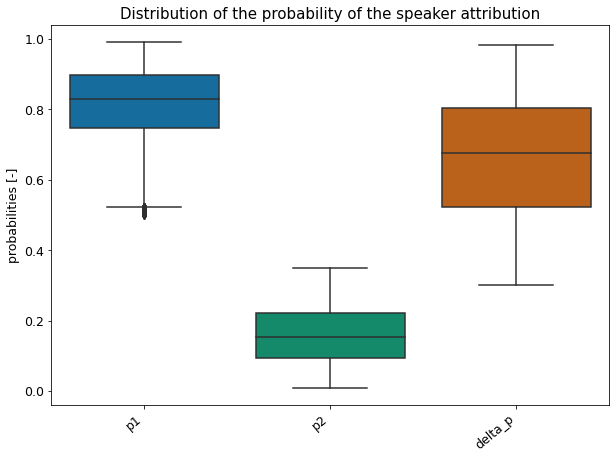

In [25]:
#boxplot to analyze the presence of outliers
data_plot = df.drop(['numOccurrences','year'], axis = 1)
ax = sns.boxplot(data = data_plot)
ax.set(ylabel='probabilities [-]')
ax.set_title('Distribution of the probability of the speaker attribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

Text(0.5, 0, 'probability')

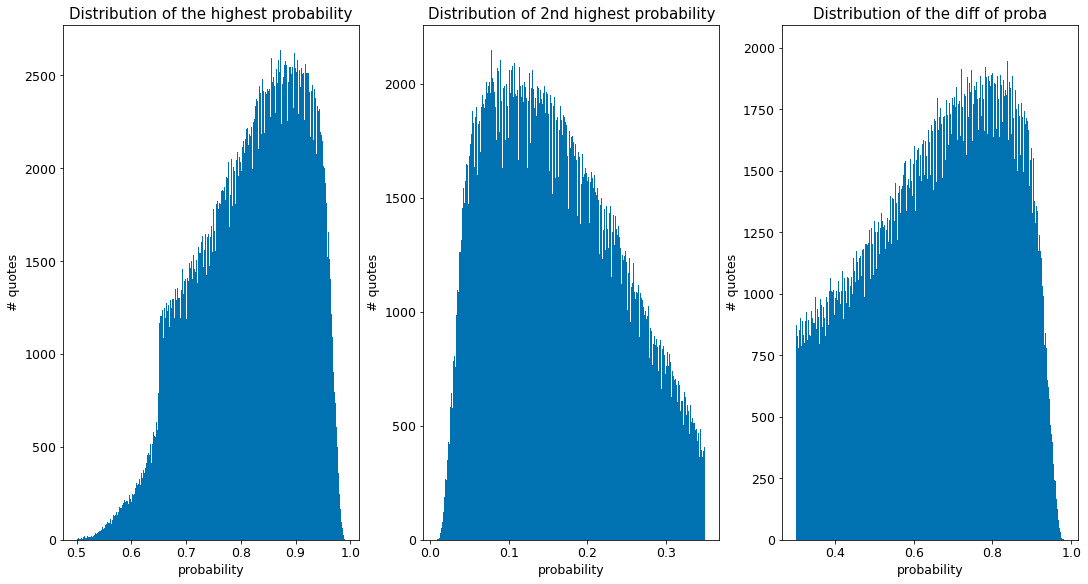

In [26]:
#histograms to better understand the distribution of the data
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 8))
ax[0].hist(df.p1, bins=500)
ax[0].set_title('Distribution of the highest probability')
ax[0].set_ylabel('# quotes')
ax[0].set_xlabel('probability')
#ax[0].set_xlim([-10000,600000])
#ax[0].set_ylim([0,340])

ax[1].hist(df.p2, bins=500)
ax[1].set_title('Distribution of 2nd highest probability')
ax[1].set_ylabel('# quotes')
ax[1].set_xlabel('probability')
#ax[1].set_xlim([-10000,600000])
#ax[1].set_ylim([0,340])

ax[2].hist(df.delta_p, bins=500)
ax[2].set_title('Distribution of the diff of proba')
ax[2].set_ylabel('# quotes')
ax[2].set_xlabel('probability')
#ax[2].set_xlim([-10000,600000])
#ax[2].set_ylim([0,340])

It seems that the outliers had been removed and that the probability distribution shows coherent behaviour. The 2 thresholds are clearly distinguishable on the left and right figures. We can notice a big gap at p=0.5 in the left figure accounting for the highest probability. Somme additionnal analyisis have to be done to better understand this behaviour of the distribution.

Quick look at the cleaned sample before exporting. 

In [27]:
df.head()

quoteID                                          quotation  \
0  2015-11-11-109291  They'll call me lots of different things. Libe...   
2  2015-09-11-070666  It's kind of the same way it's been with the R...   
4  2015-11-09-033345  I had a chuckle: They were showing a video of ...   
5  2015-09-05-038628  New Zealand will go in with a lot of confidenc...   
8  2015-02-11-042325  In his suicide note he even made a joke thanki...   

           speaker                                        qids  \
0   Chris Christie                                    [Q63879]   
2  Niklas Kronwall                                   [Q722939]   
4      Kris Draper                                   [Q948695]   
5       John Eales                                   [Q926351]   
8      Pat Buckley  [Q19956564, Q23006312, Q7143252, Q7143253]   

                 date  numOccurrences  \
0 2015-11-11 00:55:12               1   
2 2015-09-11 19:54:00               1   
4 2015-11-09 00:57:45               3   
5 2015-09-05 02:40:10               3   
8 2015-02-11 09:59:09               1   

                                              probas  \
0  [[Chris Christie, 0.7395], [Bobby Jindal, 0.15...   
2  [[Niklas Kronwall, 0.7119], [None, 0.2067], [H...   
4  [[Kris Draper, 0.8782], [None, 0.1043], [Serge...   
5  [[John Eales, 0.7896], [None, 0.2006], [Toutai...   
8            [[Pat Buckley, 0.8816], [None, 0.1184]]   

                                                urls phase      p1      p2  \
0  [http://thehill.com/blogs/ballot-box/259760-ch...     E  0.7395  0.1505   
2  [http://redwings.nhl.com/club/news.htm?id=7787...     E  0.7119  0.2067   
4  [http://ca.rd.yahoo.com/sports/rss/nfl/SIG=13u...     E  0.8782  0.1043   
5  [http://www.stuff.co.nz/sport/rugby/all-blacks...     E  0.7896  0.2006   
8  [http://independent.ie/life/health-wellbeing/m...     E  0.8816  0.1184   

   delta_p  year  
0   0.5890  2015  
2   0.5052  2015  
4   0.7739  2015  
5   0.5890  2015  
8   0.7632  2015

We can then exporting the prepared file for the next step: the comparison between this sample and the created dictionnary filled with slang words and informal expressions.
(see the `CLASSIFICATION` folder in this git)

In [ ]:
df.to_json(f"C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/Sample_cleaned_400000.json.bz2",compression="bz2",lines=True,orient="records")
